<a href="https://colab.research.google.com/github/tanmayg/LS/blob/master/diag_pred_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
PROJECT_ID = "lucid-sonar-139519"

In [8]:
import sys, os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# If you are running this notebook in Colab, follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
  !pip install witwidget --quiet
  !pip install tensorflow==1.15.0 --quiet
  !gcloud config set project $PROJECT_ID

elif "DL_PATH" in os.environ:
  !sudo pip install tabulate --quiet

Updated property [core/project].


In [0]:
BUCKET_NAME = "lsattentionmodel"
REGION = "us-central1"

In [10]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import json
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

# Should be 1.15.0
print(tf.__version__)

1.15.0


In [11]:
# Copy the data to your notebook instance
!gsutil cp 'gs://lsattentionmodel/HT_Pros_test_data_2020Jan29_0445_sample.csv' ./

Copying gs://lsattentionmodel/HT_Pros_test_data_2020Jan29_0445_sample.csv...
/ [1 files][234.9 MiB/234.9 MiB]                                                
Operation completed over 1 objects/234.9 MiB.                                    


In [0]:
from sklearn.preprocessing import StandardScaler
from keras.preprocessing import sequence

def preprocess_data(datafile, batch_size, maxlen, scaler=None):
    """ Preprocessing data and getting a sequence of word indices """
    df = pd.read_csv(datafile)
    ID = list(set(list(df.patient_id)))
    mf = (len(ID)//batch_size)*batch_size
    ID = ID[:mf]
    print("\nDataset patient count:", len(ID))
    df = df.set_index(['patient_id', 'abs_time'])
    df = df.iloc[df.index.get_level_values('patient_id').isin(ID)]
    
    #create the input & output sets for train data
    X = df.drop(['hadm_id','admittime','dischtime','charttime_hr','Hypertension_y','CHF_y','AtrialFib_y','Diabetes_y','RespFail_y','CKDL1_y','CKDL2_y','CKDL3_y','CKDL4_y','CKDL5_y','CKDL6_y','Angina_y','Ischemic_y','StableAngina_y','VentTachy_y','Tobacco_y','CardiacArr_y','Stroke_y','BrainCncr_y', 'CervclCncr_y', 'OvarnCncr_y', 'LungCncr_y', 'BreastCncr_y', 'Alzheimer_y', 'Depression_y','clm_pymt_amt_y','cum_clm_pymt_amt_y'],axis=1)
    #drop rolling mean columns
    X = X[X.columns.drop(list(X.filter(regex='_amt_rm_')))]
    #drop rolling std columns
    X = X[X.columns.drop(list(X.filter(regex='_amt_rs_')))]
    #define StdScaler Scaler for input variables
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(X[X.columns])
    X[X.columns] = scaler.transform(X[X.columns])
    #define output labels
    #Y1 = df[['Hypertension_y','CHF_y','AtrialFib_y','Diabetes_y','RespFail_y','CKDL1_y','CKDL2_y','CKDL3_y','CKDL4_y','CKDL5_y','CKDL6_y','Angina_y','Ischemic_y','StableAngina_y','VentTachy_y','Tobacco_y','CardiacArr_y','Stroke_y','BrainCncr_y', 'CervclCncr_y', 'OvarnCncr_y', 'LungCncr_y', 'BreastCncr_y', 'Alzheimer_y', 'Depression_y']]
    Y1 = df[['Hypertension_y']]
    Y1 = Y1.astype(int)

    X = X.iloc[:,:20]
    
    # train data #
    X = [X.loc[patient].values for patient in ID]
    Y1 = [Y1.loc[patient].values for patient in ID]
    
    X = sequence.pad_sequences(X, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
    Y1 = sequence.pad_sequences(Y1, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
    
    return(X, Y1, ID, scaler)

In [13]:
batch_size=128
maxlen=5
ts_in_seq, ts_out_seq, ts_ID, scaler = preprocess_data('HT_Pros_test_data_2020Jan29_0445_sample.csv', 
                                                       batch_size=batch_size, maxlen=maxlen, scaler=None)


Dataset patient count: 6144


In [14]:
ts_in_seq.shape, ts_out_seq.shape

((6144, 5, 20), (6144, 5, 1))

In [0]:
from tensorflow.keras.layers import Input, Bidirectional, CuDNNLSTM, TimeDistributed, Dense, LSTM
from tensorflow.keras.models import Model

In [16]:
#input_layer = Input(batch_shape=(batch_size, maxlen, ts_in_seq.shape[-1]))
input_layer = Input(shape=(maxlen, ts_in_seq.shape[-1]))
x = Bidirectional(CuDNNLSTM(32, batch_size=batch_size, return_sequences=True, stateful=False))(input_layer)
x = Bidirectional(CuDNNLSTM(32, batch_size=batch_size, return_sequences=True, stateful=False))(x)
output1 = TimeDistributed(Dense(1, activation='sigmoid'), name='output1')(x)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model_builtin = Model(outputs=output1, inputs=input_layer, name='builtin_predict')

In [18]:
optimizer = tf.keras.optimizers.Adam(lr=0.0002)
model_builtin.compile(optimizer = optimizer, loss={'output1': 'binary_crossentropy'}, metrics=['accuracy', 'mse'])
model_builtin.summary()

Model: "builtin_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 20)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 64)             13824     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5, 64)             25088     
_________________________________________________________________
output1 (TimeDistributed)    (None, 5, 1)              65        
Total params: 38,977
Trainable params: 38,977
Non-trainable params: 0
_________________________________________________________________


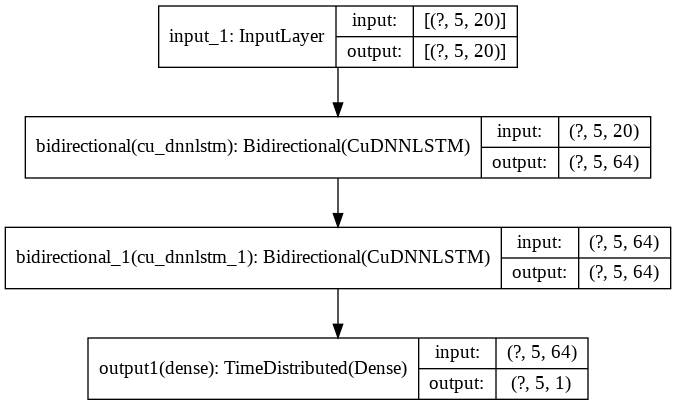

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model_builtin, show_shapes=True, show_layer_names=True)

In [20]:
model_builtin.fit(ts_in_seq, ts_out_seq, batch_size=128, shuffle=False, epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6144 samples
Epoch 1/5
6144/6144 [==============================] - 10s 2ms/sample - loss: 0.6469 - acc: 0.8043 - mean_squared_error: 0.2270
Epoch 2/5
6144/6144 [==============================] - 0s 60us/sample - loss: 0.5252 - acc: 0.8767 - mean_squared_error: 0.1687
Epoch 3/5
6144/6144 [==============================] - 0s 58us/sample - loss: 0.3989 - acc: 0.8797 - mean_squared_error: 0.1161
Epoch 4/5
6144/6144 [==============================] - 0s 51us/sample - loss: 0.3638 - acc: 0.8797 - mean_squared_error: 0.1050
Epoch 5/5
6144/6144 [==============================] - 0s 56us/sample - loss: 0.3532 - acc: 0.8797 - mean_squared_error: 0.1027


In [21]:
results = model_builtin.evaluate(ts_in_seq, ts_out_seq)
print('[val_loss, val_acc, val_mse]', results)

6144/6144 [==============================] - 5s 852us/sample - loss: 0.3492 - acc: 0.8797 - mean_squared_error: 0.1019
[val_loss, val_acc, val_mse] [0.3491825024442126, 0.87965494, 0.101889335]


In [22]:
predict = model_builtin.predict(ts_in_seq[:10])
print(ts_out_seq[np.argmax(predict, axis=-1)].tolist())

[[[[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]]], [[[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]]], [[[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]]], [[[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]]], [[[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0], [0.0]]], [[[0.0], [1.0], [0.0], [0.0], [0.0]], [[0.0], [1.0], [0.0], [0.0

In [23]:
# Preview predictions on the first 5 examples from our test dataset
for i, val in enumerate(predict):
  print('Predicted: {}'.format(val))
  print('Actual: {} \n'.format(ts_out_seq[i]))

Predicted: [[0.16124845]
 [0.15815216]
 [0.1463007 ]
 [0.12898535]
 [0.10936853]]
Actual: [[0.]
 [1.]
 [0.]
 [0.]
 [0.]] 

Predicted: [[0.12549388]
 [0.10951257]
 [0.09559047]
 [0.08568186]
 [0.08002463]]
Actual: [[0.]
 [0.]
 [0.]
 [1.]
 [0.]] 

Predicted: [[0.12692904]
 [0.11204061]
 [0.09222278]
 [0.08515105]
 [0.07739785]]
Actual: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Predicted: [[0.04191905]
 [0.04488999]
 [0.04989272]
 [0.05503368]
 [0.05988008]]
Actual: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Predicted: [[0.08855098]
 [0.09608397]
 [0.09929374]
 [0.09713814]
 [0.0918442 ]]
Actual: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Predicted: [[0.19201618]
 [0.18546516]
 [0.169063  ]
 [0.1369516 ]
 [0.11786133]]
Actual: [[1.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Predicted: [[0.11765128]
 [0.1190227 ]
 [0.10931382]
 [0.09496871]
 [0.08124101]]
Actual: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Predicted: [[0.16632876]
 [0.16215646]
 [0.15229356]
 [0.1344969 ]
 [0.11412004]]
Actual: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 

Predicted: [[0.1

In [24]:
## Convert our Keras model to an estimator
keras_estimator = tf.keras.estimator.model_to_estimator(keras_model=model_builtin, model_dir='export')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'export', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff057671518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# We need this serving input function to export our model in the next cell
serving_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(
    {'input_1': model_builtin.input},
    default_batch_size=None
)

In [26]:
#test serving func.
serving_fn = tf.estimator.export.ServingInputReceiver(
    {'input_1': model_builtin.input}
)

TypeError: ignored

In [30]:
export_path = keras_estimator.export_saved_model(
  'gs://' + BUCKET_NAME + '/explanations',
  serving_input_receiver_fn=serving_fn
).decode('utf-8')
print('export_path: ', export_path)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from export/keras/keras_model.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://lsattentionmodel/explanations/temp-b'1581794838'/saved_model.pb
export_path:  gs://lsattentionmodel/explanations/1581794838


In [31]:
!saved_model_cli show --dir $export_path --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5, 20)
        name: input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5, 1)
        name: output1/Reshape_1:0
  Method name is: tensorflow/serving/predict


In [32]:
# Print the names of our tensors
print('Model input tensor: ', model_builtin.input.name)
print('Model output tensor: ', model_builtin.output.name)

Model input tensor:  input_1:0
Model output tensor:  output1/Reshape_1:0


In [0]:
random_baseline = np.random.rand(5,20)

In [0]:
explanation_metadata = {
    "inputs": {
      "data": {
        "input_tensor_name": model_builtin.input.name,
        "input_baselines": [random_baseline.tolist()]
      }
    },
    "outputs": {
      "probability": {
        "output_tensor_name": model_builtin.output.name
      }
    },
  "framework": "tensorflow"
  }

In [0]:
# Write the json to a local file
with open('explanation_metadata.json', 'w') as output_file:
  json.dump(explanation_metadata, output_file)

In [36]:
!gsutil cp explanation_metadata.json $export_path

Copying file://explanation_metadata.json [Content-Type=application/json]...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      


In [0]:
MODEL = 'builtin_t2'

In [38]:
# Create the model if it doesn't exist yet (you only need to run this once)
!gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

Created ml engine model [projects/lucid-sonar-139519/models/builtin_t2].


In [0]:
# Each time you create a version the name should be unique
VERSION = 'v1'

In [40]:
# Create the version with gcloud
explain_method = 'integrated-gradients'
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-integral-steps 25

Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
ERROR: (gcloud.beta.ai-platform.versions.create) Model explanation failed: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:


In [79]:
# Make sure the model deployed correctly. State should be `READY` in the following log
!gcloud ai-platform versions describe $VERSION --model $MODEL

createTime: '2020-02-15T19:02:03Z'
deploymentUri: gs://lsattentionmodel/explanations/1581792943
etag: HOCEvjqeGWQ=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/lucid-sonar-139519/models/builtin_t1/versions/v1
pythonVersion: '3.7'
runtimeVersion: '1.15'
state: READY


In [0]:
# Format data for prediction to our model
prediction_json = {'input_1': ts_in_seq[:5].tolist()}

In [0]:
ts_in_seq[:5].reshape(-1,20)

In [0]:
with open('builtin_t.txt', 'w') as outfile:
  json.dump(prediction_json, outfile)

In [82]:
!echo $MODEL
!echo $VERSION

builtin_t1
v1


In [84]:
# Preview the contents of the data file
!cat builtin_t.txt

{"input_1": [[[0.722659707069397, -0.4126410186290741, -0.35629597306251526, 0.8474864959716797, -0.8474864959716797, -0.015348331071436405, -0.3414861857891083, -0.13692672550678253, -0.20233982801437378, 0.44033437967300415, -0.27579939365386963, 0.27579939365386963, -0.045349448919296265, -0.15834547579288483, -0.04459831863641739, -0.059825967997312546, -0.06977451592683792, -0.04927809536457062, -0.06829848885536194, 0.0], [0.722659707069397, -0.4126410186290741, -0.35629597306251526, 0.8474864959716797, -0.8474864959716797, -0.015348331071436405, -0.3414861857891083, -0.13692672550678253, -0.20233982801437378, 0.44033437967300415, -0.27579939365386963, 0.27579939365386963, -0.045349448919296265, -0.15834547579288483, -0.04459831863641739, -0.059825967997312546, -0.06977451592683792, -0.04927809536457062, -0.06829848885536194, 0.0], [0.722659707069397, -0.4126410186290741, -0.35629597306251526, 0.8474864959716797, -0.8474864959716797, -0.015348331071436405, -0.3414861857891083, -0

In [83]:
!gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='builtin_t.txt'

{
  "error": "Explainability failed with exception: <_InactiveRpcError of RPC that terminated with:\n\tstatus = StatusCode.INVALID_ARGUMENT\n\tdetails = \"transpose expects a vector of size 4. But input(1) is a vector of size 3\n\t [[{{node bidirectional/forward_lstm_1/transpose}}]]\"\n\tdebug_error_string = \"{\"created\":\"@1581793778.223223989\",\"description\":\"Error received from peer ipv4:10.55.253.203:8500\",\"file\":\"src/core/lib/surface/call.cc\",\"file_line\":1056,\"grpc_message\":\"transpose expects a vector of size 4. But input(1) is a vector of size 3\\n\\t [[{{node bidirectional/forward_lstm_1/transpose}}]]\",\"grpc_status\":3}\"\n>"
}


In [45]:
resp_obj = !gcloud beta ai-platform explain --model $MODEL --version $VERSION --json-instances='builtin_test.txt'
response = json.loads(resp_obj.s)

JSONDecodeError: ignored

In [77]:
resp_obj

['{',
 '  "error": "Explainability failed with exception: <_InactiveRpcError of RPC that terminated with:\\n\\tstatus = StatusCode.INVALID_ARGUMENT\\n\\tdetails = \\"Shapes of all inputs must match: values[0].shape = [26] != values[1].shape = [1,52]\\n\\t [[{{node stack}}]]\\"\\n\\tdebug_error_string = \\"{\\"created\\":\\"@1581740964.058777580\\",\\"description\\":\\"Error received from peer ipv4:10.55.244.33:8500\\",\\"file\\":\\"src/core/lib/surface/call.cc\\",\\"file_line\\":1056,\\"grpc_message\\":\\"Shapes of all inputs must match: values[0].shape = [26] != values[1].shape = [1,52]\\\\n\\\\t [[{{node stack}}]]\\",\\"grpc_status\\":3}\\"\\n>"',
 '}']

In [42]:
!gcloud beta ai-platform explain --model $MODEL --version $VERSION
predicted = round(explanations['example_score'], 2)
print('Predicted duration: ' + str(predicted))
print('Actual duration: ' + str(test_labels.iloc[0]))

ERROR: (gcloud.beta.ai-platform.explain) Exactly one of (--json-instances | --text-instances) must be specified.
Usage: gcloud beta ai-platform explain --model=MODEL (--json-instances=JSON_INSTANCES | --text-instances=TEXT_INSTANCES) [optional flags]
  optional flags may be  --help | --json-instances | --text-instances |
                         --version

For detailed information on this command and its flags, run:
  gcloud beta ai-platform explain --help


NameError: ignored